# Fake News Analysis and Classification (Google Colab edition)

This notebook performs exploratory data analysis (EDA) on the fake news dataset and evaluates different classification models. 
This notebook is designed to run on Google Colab to leverage GPU acceleration for training our fake news detection models, particularly the DistilBERT transformer model which benefits significantly from GPU processing. (I created this notebook as my computer does not support GPU training.)

In [ ]:
!git clone https://github.com/smaoui-me/fake-news-predictor.git

Cloning into 'fake-news-predictor'...


In [ ]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('/content/fake-news-predictor')  # Path to the repo root

from models import load_data, LogisticModel, DistilBertModel

## 1. Load and Explore the Dataset

In [ ]:
# Load the dataset
data = load_data('/content/fake-news-predictor/data/fake_news_dataset.csv')
df = data['full_data']

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:\n{df['label'].value_counts()}")
print(f"\nClass distribution (percentage):\n{df['label'].value_counts(normalize=True) * 100}")

Dataset shape: (4000, 24)

Class distribution:
label
Fake    2026
Real    1974
Name: count, dtype: int64

Class distribution (percentage):
label
Fake    50.65
Real    49.35
Name: proportion, dtype: float64


In [ ]:
# Display sample data
df.head()

,id,title,author,text,state,date_published,source,category,sentiment_score,word_count,...,num_shares,num_comments,political_bias,fact_check_rating,is_satirical,trust_score,source_reputation,clickbait_score,plagiarism_score,label
0,1,Breaking News 1,Jane Smith,This is the content of article 1. It contains ...,Tennessee,30-11-2021,The Onion,Entertainment,-0.22,1302,...,47305,450,Center,FALSE,1,76,6,0.84,53.35,Fake
1,2,Breaking News 2,Emily Davis,This is the content of article 2. It contains ...,Wisconsin,02-09-2021,The Guardian,Technology,0.92,322,...,39804,530,Left,Mixed,1,1,5,0.85,28.28,Fake
2,3,Breaking News 3,John Doe,This is the content of article 3. It contains ...,Missouri,13-04-2021,New York Times,Sports,0.25,228,...,45860,763,Center,Mixed,0,57,1,0.72,0.38,Fake
3,4,Breaking News 4,Alex Johnson,This is the content of article 4. It contains ...,North Carolina,08-03-2020,CNN,Sports,0.94,155,...,34222,945,Center,TRUE,1,18,10,0.92,32.20,Fake
4,5,Breaking News 5,Emily Davis,This is the content of article 5. It contains ...,California,23-03-2022,Daily Mail,Technology,-0.01,962,...,35934,433,Right,Mixed,0,95,6,0.66,77.70,Real


In [ ]:
df.tail()

,id,title,author,text,state,date_published,source,category,sentiment_score,word_count,...,num_shares,num_comments,political_bias,fact_check_rating,is_satirical,trust_score,source_reputation,clickbait_score,plagiarism_score,label
3995,3996,Breaking News 3996,John Doe,This is the content of article 3996. It contai...,Ohio,25-04-2020,InfoWars,Technology,0.91,1227,...,38880,697,Right,Mixed,0,29,10,0.22,95.46,Fake
3996,3997,Breaking News 3997,Alex Johnson,This is the content of article 3997. It contai...,Washington,09-01-2022,CNN,Sports,-0.57,1296,...,3650,925,Left,FALSE,1,53,3,0.42,16.54,Fake
3997,3998,Breaking News 3998,Alex Johnson,This is the content of article 3998. It contai...,California,03-03-2023,Breitbart,Entertainment,-0.17,522,...,35391,577,Left,FALSE,0,22,9,0.50,28.51,Fake
3998,3999,Breaking News 3999,John Doe,This is the content of article 3999. It contai...,Illinois,13-04-2021,New York Times,Health,-0.88,169,...,40424,201,Left,FALSE,1,3,6,0.17,71.16,Real
3999,4000,Breaking News 4000,John Doe,This is the content of article 4000. It contai...,Texas,20-12-2023,The Guardian,Health,-0.95,465,...,48913,279,Right,TRUE,1,73,4,0.09,27.65,Real


## 2. Exploratory Data Analysis

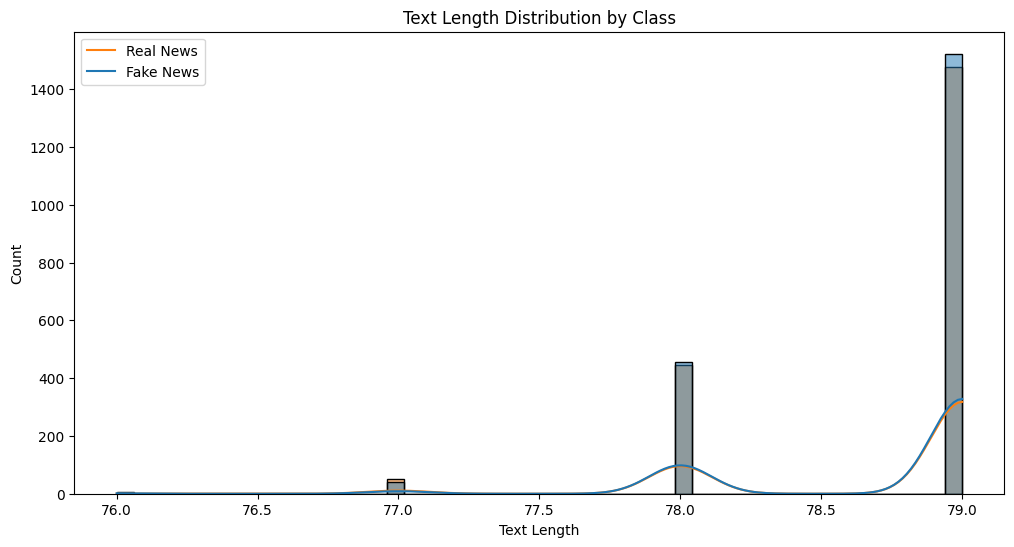

In [ ]:
# Text length distribution
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_length', hue='label', bins=50, kde=True)
plt.title('Text Length Distribution by Class')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.legend(['Real News', 'Fake News'])
plt.show()

In [ ]:
# 1. Check for missing or null values
print("Checking for missing values:")
missing_values = df.isnull().sum()
print(missing_values)

# 2. Check label distribution and ensure binary classes
print("\nLabel distribution before cleaning:")
print(df['label'].value_counts())
print("\nUnique labels:", df['label'].unique())

# 3. Check for duplicates
duplicate_count = df.duplicated(['text', 'label']).sum()
print(f"\nNumber of duplicate entries (same text and label): {duplicate_count}")

# Clean the data
# Remove missing values
df = df.dropna()

# Ensure binary labels (0 for Real, 1 for Fake)
if df['label'].dtype == object:
    label_map = {'Real': 0, 'Fake': 1}
    df['label'] = df['label'].map(label_map)

# Remove duplicates
df = df.drop_duplicates(subset=['text', 'label'])

# Show cleaned data stats
print("\nAfter cleaning:")
print(f"Total samples: {len(df)}")
print("\nLabel distribution after cleaning:")
print(df['label'].value_counts())

Checking for missing values:
id                   0
title                0
author               0
text                 0
state                0
date_published       0
source               0
category             0
sentiment_score      0
word_count           0
char_count           0
has_images           0
has_videos           0
readability_score    0
num_shares           0
num_comments         0
political_bias       0
fact_check_rating    0
is_satirical         0
trust_score          0
source_reputation    0
clickbait_score      0
plagiarism_score     0
label                0
text_length          0
dtype: int64

Label distribution before cleaning:
label
Fake    2026
Real    1974
Name: count, dtype: int64

Unique labels: ['Fake' 'Real']

Number of duplicate entries (same text and label): 0

After cleaning:
Total samples: 4000

Label distribution after cleaning:
label
1    2026
0    1974
Name: count, dtype: int64


## 3. Train and Evaluate Logistic Regression Model

Logistic Regression Model Metrics:
Accuracy: 0.5062
Precision: 0.5062
Recall: 1.0000
F1_score: 0.6722


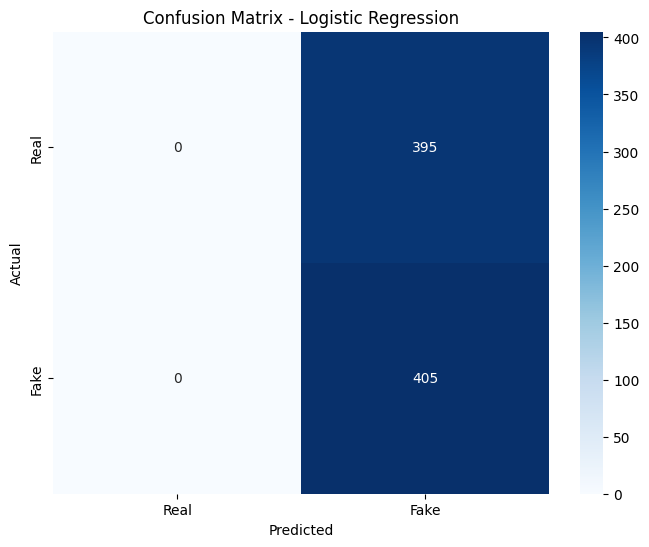

In [ ]:
# Initialize and train the Logistic Regression model
logistic_model = LogisticModel(max_features=10000, preprocess=True)
logistic_model.train(data['train']['texts'], data['train']['labels'])

# Convert string labels to numeric
if data['train']['labels'].dtype == object:  # Check if labels are strings
    # Map 'Real' to 0 and 'Fake' to 1
    data['train']['labels'] = data['train']['labels'].map({'Real': 0, 'Fake': 1})
    data['test']['labels'] = data['test']['labels'].map({'Real': 0, 'Fake': 1})

# Initialize and train the Logistic Regression model
logistic_model = LogisticModel(max_features=10000, preprocess=True)
logistic_model.train(data['train']['texts'], data['train']['labels'])



# Evaluate the model
logistic_metrics = logistic_model.evaluate(data['test']['texts'], data['test']['labels'])

# Display metrics
print("Logistic Regression Model Metrics:")
for metric, value in logistic_metrics.items():
    if metric != 'confusion_matrix':
        print(f"{metric.capitalize()}: {value:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    logistic_metrics['confusion_matrix'],
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Real', 'Fake'],
    yticklabels=['Real', 'Fake']
)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save the model
logistic_model.save('../models/logistic_model.pkl')

## 4. Train and Evaluate DistilBERT Model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4 - Average Loss: 0.6953
Epoch 2/4 - Average Loss: 0.6945
Epoch 3/4 - Average Loss: 0.6941
Epoch 4/4 - Average Loss: 0.6942
DistilBERT Model Metrics:
Accuracy: 0.5262
Precision: 0.5195
Recall: 0.8543
F1_score: 0.6461


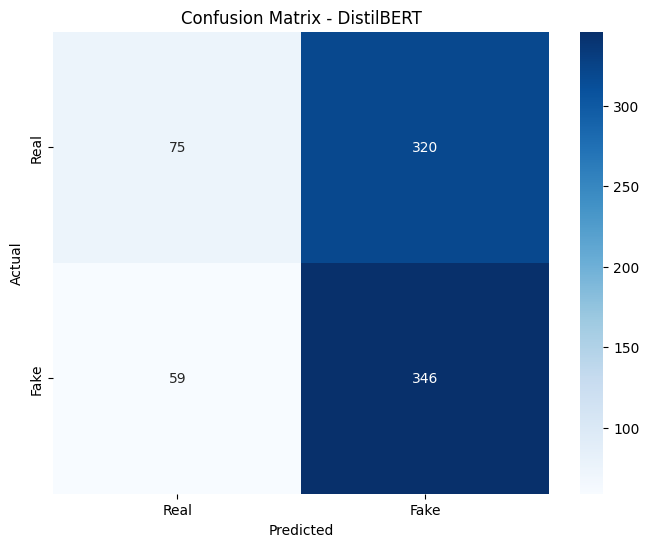

In [ ]:
# Initialize and train the DistilBERT model
# Note: This may take some time to run
distilbert_model = DistilBertModel(max_length=128, batch_size=16, epochs=4)
distilbert_model.train(data['train']['texts'], data['train']['labels'])

# Evaluate the model
distilbert_metrics = distilbert_model.evaluate(data['test']['texts'], data['test']['labels'])

# Display metrics
print("DistilBERT Model Metrics:")
for metric, value in distilbert_metrics.items():
    if metric != 'confusion_matrix':
        print(f"{metric.capitalize()}: {value:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    distilbert_metrics['confusion_matrix'],
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Real', 'Fake'],
    yticklabels=['Real', 'Fake']
)
plt.title('Confusion Matrix - DistilBERT')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save the model
distilbert_model.save('../models/distilbert_model')

## 5. Compare Model Performance

In [ ]:
# Compare model performance
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
models = ['Logistic Regression', 'DistilBERT']
performance = {
    'Logistic Regression': [logistic_metrics[metric] for metric in metrics],
    'DistilBERT': [distilbert_metrics[metric] for metric in metrics]
}

# Create a DataFrame for comparison
performance_df = pd.DataFrame(performance, index=metrics)
performance_df.index = [metric.capitalize() for metric in metrics]

# Display the comparison
performance_df

,Logistic Regression,DistilBERT
Accuracy,0.506250,0.526250
Precision,0.506250,0.519520
Recall,1.000000,0.854321
F1_score,0.672199,0.646125


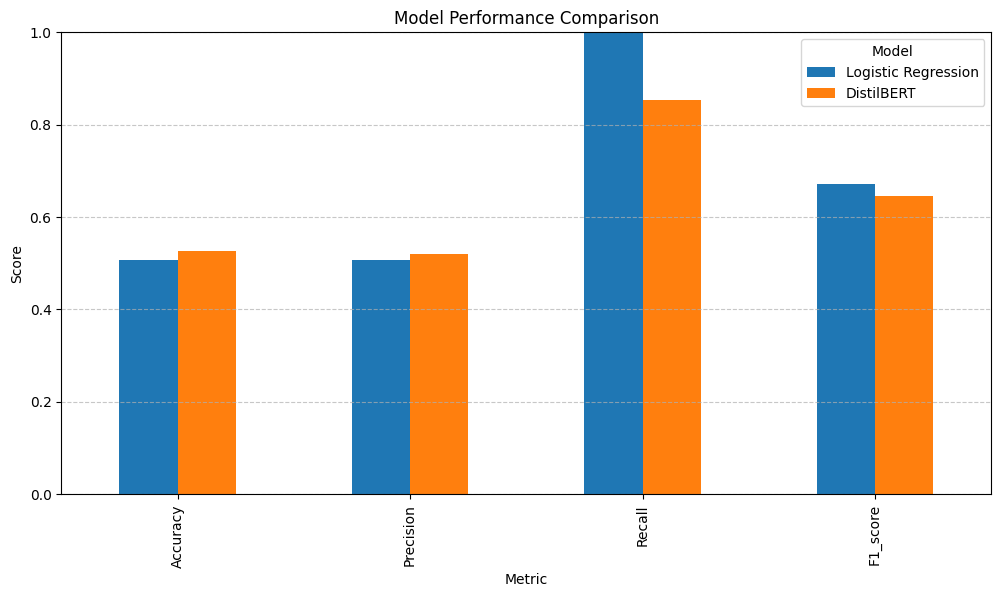

In [ ]:
# Plot the comparison
performance_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 6. Example Predictions

In [ ]:
# Get some examples from the test set
examples = data['test']['texts'].iloc[:5].tolist()
true_labels = data['test']['labels'].iloc[:5].tolist()

# Make predictions with both models
logistic_preds = logistic_model.predict(examples)
distilbert_preds = distilbert_model.predict(examples)

# Display the results
results = pd.DataFrame({
    'Text': [text[:100] + '...' for text in examples],
    'True Label': true_labels,
    'Logistic Prediction': logistic_preds,
    'DistilBERT Prediction': distilbert_preds
})

results

,Text,True Label,Logistic Prediction,DistilBERT Prediction
0,This is the content of article 1671. It contai...,0,1,1
1,This is the content of article 3422. It contai...,0,1,0
2,This is the content of article 1121. It contai...,1,1,1
3,This is the content of article 268. It contain...,0,1,1
4,This is the content of article 3735. It contai...,1,1,1
